In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay 
import skimage as sk
import scipy as sci
import scipy.interpolate


In [3]:
im1 = plt.imread('../../Morphing/Photos/meRescaled.jpg')
im2 = plt.imread('../../Morphing/Photos/chadRescaled.jpg')

In [6]:
with open('../../Morphing/Photos/corrv2.json') as jsonFile:
    keyPoints = json.load(jsonFile)
keyPoints['im1Points'].extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
keyPoints['im1Points'].extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])
keyPoints['im2Points'].extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
keyPoints['im2Points'].extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])
im1Points = np.array(keyPoints['im1Points'])
im2Points = np.array(keyPoints['im2Points'])

In [7]:
np.average([im2Points[0], im2Points[0]], axis=0)

array([228., 458.])

In [28]:
averagePoints = [np.average(a, weights=[0.5, 0.5], axis=0) for a in zip(im1Points, im2Points)]
averagePoints = np.array(averagePoints)
print(averagePoints.shape)

(75, 2)


In [29]:
triAverage = Delaunay(averagePoints) 
triIm1 = Delaunay(im1Points)
triIm2 = Delaunay(im2Points)

In [272]:
#Average tri on img2 face
# fig = plt.figure()
# fig, ax = plt.subplots()
# img = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
# ax.imshow(img)

# plt.triplot(im2Points[:,0], im2Points[:,1], triIm2.simplices)
# plt.plot(im2Points[:,0], im2Points[:,1], 'o')
# ax.set_aspect('equal', adjustable='box')

<Figure size 640x480 with 0 Axes>

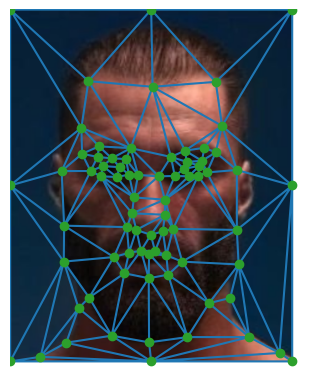

In [18]:
#Average tri on img2 face
fig = plt.figure()
fig, ax = plt.subplots()
ax.imshow(im2)
plt.axis("off")

plt.triplot(im2Points[:,0], im2Points[:,1], triIm2.simplices)
plt.plot(im2Points[:,0], im2Points[:,1], 'o')
ax.set_aspect('equal', adjustable='box')
# plt.savefig("../morphOut/webPhotos/chadkeypoint.jpg", bbox_inches='tight')


In [23]:
#Triangle Vert is a 3x2 array
def imgToTriangle(triangleVert, img):
    mask = sk.draw.polygon2mask(img.shape[0:3], triangleVert)
    # print(mask.shape)
    return img * mask
   #return np.stack(img[:,:,0] * mask, img[:,:,1] * mask, img[:,:,2] * mask, axis=2)

In [24]:
#Inverse transform from t1 to t2
def affineTrans(triIndex, t1Points, t1Simplicies, t2Points):
    t1 = [t1Points[i] for i in t1Simplicies[triIndex]]
    t2 = [t2Points[i] for i in t1Simplicies[triIndex]]
    # print(t1)
    # print(t2)
    t1Vec = np.array([t1[0] - t1[1],  t1[0] - t1[2]]).T
    t2Vec = np.array([t2[0] - t2[1],  t2[0] - t2[2]]).T
    # print(t1Vec)
    # print(t2Vec)
    t1VecToRight = np.eye(3)
    t1VecToRight[0:2, 0:2] = t1Vec
    t1VecToRight[0:2, 2] = t1[0]
    t1VecToRight = np.linalg.inv(t1VecToRight)

    rightToT2 = np.eye(3)
    rightToT2[0:2, 0:2] = t2Vec
    rightToT2[0:2, 2] = t2[0]

    return rightToT2 @ t1VecToRight
    

In [35]:
def warpImg(im1Points, im1Tri, im2Points, img):
    warpedIm2 = np.zeros_like(img).astype(np.float64)
    for i in range(0, len(im1Tri.simplices)):
        maskedIm2 = imgToTriangle([[im2Points[i][1],im2Points[i][0]] for i in im1Tri.simplices[i]], img)
        inverseMap = affineTrans(i, im1Points, triAverage.simplices, im2Points)
        warpedIm2 += sk.transform.warp(maskedIm2, inverseMap)
    return warpedIm2

In [39]:
def warpWithRatio(im1, im1Points, im2, im2Points, crossRatio, morphRatio):
    # averageImg = np.average([im2Points[0], im2Points[0]], weights=[morphRatio, 1-morphRatio], axis=0)
    averagePoints = [np.average(a, weights=[morphRatio, 1-morphRatio], axis=0) for a in zip(im1Points, im2Points)]
    averagePoints = np.array(averagePoints) 
    triAverage = Delaunay(averagePoints)
    img1Warp = warpImg(averagePoints, triAverage, im1Points, im1)
    img2Warp = warpImg(averagePoints, triAverage, im2Points, im2)
    interpolatedImg = img1Warp * crossRatio + img2Warp * (1-crossRatio)
    
    return interpolatedImg

In [40]:
midWayFace = warpWithRatio(im1, im1Points, im2, im2Points, 0.5, 0.5)

In [41]:
np.max(midWayFace)

np.float64(5.2705882352937525)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010409658251329596..5.2705882352937525].


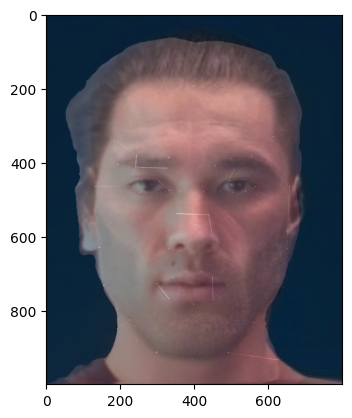

In [42]:
plt.imshow(midWayFace)

In [43]:
# plt.imsave("../morphOut/webPhotos/midwayFace.jpg", np.clip(midWayFace,0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.215686274509804].


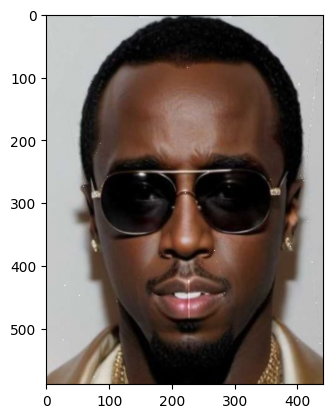

In [251]:
diddyAvg = warpImg(averagePoints, triAverage, im1Points, diddyImg)
plt.imshow(diddyAvg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.4001338576744056].


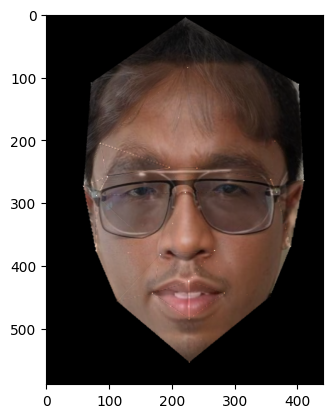

In [199]:
thomasDiddyMerge = ((thomasAvg + diddyAvg)/2)
# thomasDiddyMerge = thomasDiddyMerge/np.max(thomasDiddyMerge)
plt.imshow(thomasDiddyMerge)

In [ ]:
sci.interpolate.griddata(warpedIm2[:,:,0])

In [25]:
im2Points[20]

array([255, 613])

In [17]:
#using 0 index vertice as right angle
triangleVector1 = np.array([im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][1]],  im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][2]]]).T
print(triangleVector1)

[[   1  190]
 [-107 -118]]


In [13]:
triangleVector1 = np.array([im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][1]],  im2Points[triIm2.simplices[0][0]] - im2Points[triIm2.simplices[0][2]]]).T
t2_to_right_angle = np.eye(3)
t2_to_right_angle[0:2, 0:2] = triangleVector1
t2_to_right_angle[0:2, 2] = im2Points[triIm2.simplices[0][0]]
t2_to_right_angle

array([[   1.,  190.,  367.],
       [-107., -118.,  176.],
       [   0.,    0.,    1.]])

In [23]:
inverseT2_to_right_angle = np.linalg.inv(t2_to_right_angle)
print(inverseT2_to_right_angle)

[[-5.83811597e-03 -9.40035622e-03  3.79705126e+00]
 [ 5.29388482e-03  4.94755591e-05 -1.95156343e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [22]:
#using 0 index vertice as right angle
triangleVectorAverage = np.array([averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][1]],  averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][2]]]).T
tright_angle_to_average = np.eye(3)
tright_angle_to_average[0:2, 0:2] = triangleVectorAverage
tright_angle_to_average[0:2, 2] = averagePoints[triAverage.simplices[0][0]]
print(tright_angle_to_average)

[[   1.  190.  367.]
 [-107. -118.  176.]
 [   0.    0.    1.]]


In [21]:
t2_to_average = tright_angle_to_average @ inverseT2_to_right_angle
print(t2_to_average)

[[1.00000000e+00 1.04354459e-18 0.00000000e+00]
 [6.93889390e-18 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
